### Priority
* First, analyze and get the statistics for each df_cell
* Determine whether keep going with unit x state manner
* Attention is related to grasp the important pattern?
* Short chromosome can be mixed up in the sample?
* Prepare all the prerequisites before we enter the pretrain step

In [1]:
from platform import python_version
python_version()

'3.8.3'

In [3]:
# import torch 
# torch.cuda.is_available()

In [4]:
import os
import pandas as pd
import json
import tqdm
import re
import seaborn as sns

In [5]:
import pickle

In [6]:
import css_utility

In [7]:
from css_utility import colored_css_str

In [8]:
from css_utility import all_files, all_cell_pickles, state_col_dict
from css_utility import state_dict,css_name,css_dict,css_color_dict
from css_utility import file_list_maker,colors2color_dec,bed2df_as_is
from css_utility import bed2df_expanded,total_df_maker,numchr,df2css_allchr
from css_utility import df2chr_index,df2css_chr,df2css_chr_str,css_list2count
from css_utility import colored_css_str

In [10]:
### write and test the quiescent region removal

test_file_bed=all_files[0]
df=bed2df_expanded(test_file_bed)
print("test file name: ", test_file_bed)

test file name:  ../database/bed/unzipped/E119_15_coreMarks_stateno.bed


In [11]:
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,28400,15,28400,284,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,28400,28800,1,400,4,A,AAAA
2,chr1,28800,540400,15,511600,5116,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,713200,15,172400,1724,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [12]:
df["chromosome"].iloc[45244]

'chr2'

In [13]:
df[["chromosome","length","state_seq_full"]].iloc[:3]

,chromosome,length,state_seq_full
0,chr1,28400,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,400,AAAA
2,chr1,511600,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [14]:
df[["chromosome","length","state_seq_full"]].iloc[45242:45245]

,chromosome,length,state_seq_full
45242,chr2,31800,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
45243,chr2,11600,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45244,chr2,1600,GGGGGGGGGGGGGGGG


In [15]:
# sort by the length of the state_seq_full (and analyze its distribution)
# 1. for one chromosome, group O only
# 2. bar graph for the length (distribution)
# 3. sort the length and see the index where it is located

In [16]:
df["chromosome"][0:45244].tail()

45239    chr2
45240    chr2
45241    chr2
45242    chr2
45243    chr2
Name: chromosome, dtype: object

In [17]:
df[0:45244].tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
45239,chr2,29679200,29685200,15,6000,60,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45240,chr2,29685200,29687000,7,1800,18,G,GGGGGGGGGGGGGGGGGG
45241,chr2,29687000,29698400,15,11400,114,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45242,chr2,29698400,29730200,14,31800,318,N,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
45243,chr2,29730200,29741800,15,11600,116,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [18]:
def df2chr_df(df):
   
    """Create a list of dataframes, each of which containing 
    the the whole expanded type of dataframe per chromosome"""
    
    start=0
    df_chr_list=[]
    chr_index=df2chr_index(df)
    
    for index in chr_index:
        df_chr=df[start:index+1] # note that python [i:j] means from i to j-1
        chr_name=df["chromosome"].iloc[start] # string, such as chr1, chr2, ...
        df_name='df_'+chr_name  # the chromosome-wise data stored like df_chr1, df_chr2, ...
        locals()[df_name]=df_chr # make a string into a variable name
        df_chr_list.append(df_chr)
        start=index+1
    
    return df_chr_list      # elm is the df of each chromosome

In [19]:
df_chr_list=df2chr_df(df)

In [20]:
df_chr_list[0].tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
39926,chr1,249210800,249212600,4,1800,18,D,DDDDDDDDDDDDDDDDDD
39927,chr1,249212600,249214200,5,1600,16,E,EEEEEEEEEEEEEEEE
39928,chr1,249214200,249239400,15,25200,252,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
39929,chr1,249239400,249240200,9,800,8,I,IIIIIIII
39930,chr1,249240200,249250600,15,10400,104,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [21]:
chr1df=df_chr_list[0]

In [22]:
chr1df.tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
39926,chr1,249210800,249212600,4,1800,18,D,DDDDDDDDDDDDDDDDDD
39927,chr1,249212600,249214200,5,1600,16,E,EEEEEEEEEEEEEEEE
39928,chr1,249214200,249239400,15,25200,252,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
39929,chr1,249239400,249240200,9,800,8,I,IIIIIIII
39930,chr1,249240200,249250600,15,10400,104,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [23]:
len(chr1df)

39931

In [24]:
chr1df_o=chr1df[chr1df["state"]==15]
chr1df_o.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,28400,15,28400,284,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
2,chr1,28800,540400,15,511600,5116,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
4,chr1,540800,713200,15,172400,1724,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
6,chr1,715600,723800,15,8200,82,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
8,chr1,727400,752200,15,24800,248,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [25]:
len(chr1df_o)

6354

In [26]:
chr1df_o_sorted=chr1df_o.sort_values(by=["length"], ascending=False)

In [27]:
chr1df_o_sorted.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
22285,chr1,121485600,142535200,15,21049600,210496,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3268,chr1,13188200,13787400,15,599200,5992,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
30280,chr1,188676400,189237200,15,560800,5608,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
30328,chr1,191252400,191791600,15,539200,5392,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
2,chr1,28800,540400,15,511600,5116,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [28]:
chr1df_o.loc[:,"unit"].describe()

count      6354.000000
mean        245.072081
std        2661.893722
min           2.000000
25%          64.000000
50%         116.000000
75%         224.000000
max      210496.000000
Name: unit, dtype: float64

In [29]:
chr1df_o.index

Int64Index([    0,     2,     4,     6,     8,    12,    22,    24,    92,
              106,
            ...
            39872, 39874, 39876, 39878, 39880, 39897, 39918, 39923, 39928,
            39930],
           dtype='int64', length=6354)

<AxesSubplot:>

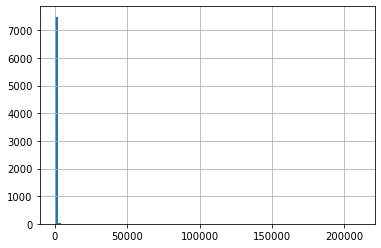

In [27]:
chr1df_o.loc[:,"unit"].hist(bins=100)

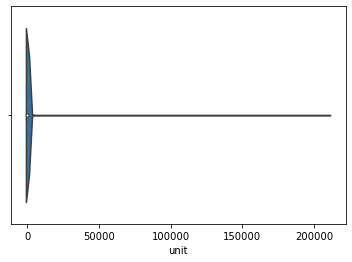

In [28]:
ax1=sns.violinplot(x=chr1df_o["unit"])

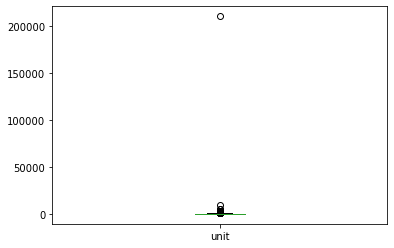

In [29]:
ax2=chr1df_o["unit"].plot.box()

In [34]:
chr1df_o_overmean=chr1df_o[chr1df_o["unit"]>chr1df_o["unit"].mean()]
len(chr1df_o_overmean)

1937

In [36]:
chr1df_o_overmean["unit"].describe()

count      1937.000000
mean        599.522974
std        4790.914402
min         224.000000
25%         282.000000
50%         368.000000
75%         538.000000
max      210496.000000
Name: unit, dtype: float64

In [34]:
##remove the 15th state from the df
df.head(100)

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,28400,15,28400,284,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,28400,28800,1,400,4,A,AAAA
2,chr1,28800,540400,15,511600,5116,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,713200,15,172400,1724,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
...,...,...,...,...,...,...,...,...
95,chr1,933200,933800,13,600,6,M,MMMMMM
96,chr1,933800,934400,12,600,6,L,LLLLLL
97,chr1,934400,936200,11,1800,18,K,KKKKKKKKKKKKKKKKKK
98,chr1,936200,936800,10,600,6,J,JJJJJJ


In [31]:
df_wo_o=df[df["state"]!=15]

In [33]:
df_wo_o.head(10)

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
1,chr1,28400,28800,1,400,4,A,AAAA
3,chr1,540400,540800,1,400,4,A,AAAA
5,chr1,713200,715600,1,2400,24,A,AAAAAAAAAAAAAAAAAAAAAAAA
7,chr1,723800,727400,9,3600,36,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
9,chr1,752200,752400,7,200,2,G,GG
10,chr1,752400,752800,2,400,4,B,BBBB
11,chr1,752800,754200,7,1400,14,G,GGGGGGGGGGGGGG
13,chr1,760800,761200,7,400,4,G,GGGG
14,chr1,761200,761400,2,200,2,B,BB
15,chr1,761400,763800,1,2400,24,A,AAAAAAAAAAAAAAAAAAAAAAAA


In [35]:
sample=df_wo_o.head(10)

In [49]:
lst=[]
str_elm=sample["state_seq_full"].iloc[0]
str_elm

'AAAA'

In [57]:
lst=[]
str_elm=sample["state_seq_full"].iloc[0]
for i in range(1, len(sample)):
    cid=sample.index[i]
    pid=sample.index[i-1]
    ssf=sample["state_seq_full"]
    if (cid-pid)!=1:
        lst.append(str_elm)
        str_elm=ssf.iloc[i]
    else:
        str_elm+=ssf.iloc[i]
        if i==len(sample)-1:
            lst.append(str_elm)
lst

['AAAA',
 'AAAA',
 'AAAAAAAAAAAAAAAAAAAAAAAA',
 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII',
 'GGBBBBGGGGGGGGGGGGGG',
 'GGGGBBAAAAAAAAAAAAAAAAAAAAAAAA']

In [59]:
len(sample)

10

In [ ]:
# but, we need to know where the 15th state was, to segmentize the sequences

state15_index_list=[]
for index_num in 

In [79]:
# input= dataframe, output=a list of segmented css except for 15th state

def df2segment_index_bad(df):
    """Generate two lists: 15 state start point list / end point list
    input should be a df """
    total_row=len(df)
    state_o_start=[]
    state_o_end=[]
    
    # collect the start and end index where state=15
    for row_num in range(total_row-1):
        if (df["state"].iloc[row_num]==15):
            if row_num==0:
                state_o_start.append(row_num)
            elif (row_num<total_row-1) & (df["state"].iloc[row_num-1]!=15): # middle position: when 15 stars
                state_o_start.append(row_num)
            elif (row_num<total_row-1) & (df["state"].iloc[row_num+1]!=15): # middle position: when 15 ends
                state_o_end.append(row_num)
            elif row_num==total_row-1:
                state_o_end.append(row_num)
    return state_o_start, state_o_end

In [ ]:
# the above code is not good. Obtain just the location of 15, and then find the start and end index
# of the "other" states

# maybe good for the chromosome-wise df?
def df2segment_index(df):
    total_index=df.index
    rem_index=df[df["state"]!=15].index  # a list of index where state=15
    solo_list=[]
    conn_list=[]
    
    # then the start should be the "between" of these indices
    for row_num in rem_index:
        if (row_num+1 not in rem_index) & (row_num-1 not in rem_index):  # solo-list
            solos_list.append(df["state_seq_full"].iloc[row_num])
        elif:
            ###################################################################
            ###################################################################
            ###################################################################
            ###################################################################
            ###################################################################
            ###################################################################
            ###################################################################
            ###################################################################
        
            
    


In [108]:
total_index=df.index
o_index=df[df["state"]==15].index
rem_index=df[df["state"]!=15].index

In [110]:
rem_index

Int64Index([     1,      3,      5,      7,      8,      9,     10,     12,
                14,     15,
            ...
            510137, 510138, 510139, 510140, 510141, 510142, 510143, 510144,
            510146, 510148],
           dtype='int64', length=412566)

In [126]:
css_inde=[]
check_list=[]
for row_num in rem_index:
    if (row_num+1 not in rem_index) & (row_num-1 not in rem_index):
        check_list.append(row_num)
#         df["state_seq_full"].iloc[row_num]
print(check_list)

[1, 3, 5, 12, 131, 238, 264, 296, 341, 343, 448, 500, 502, 622, 667, 697, 699, 701, 703, 705, 710, 712, 714, 716, 718, 728, 751, 756, 758, 813, 815, 829, 930, 962, 964, 969, 971, 973, 975, 980, 982, 987, 989, 991, 993, 999, 1001, 1003, 1005, 1007, 1009, 1015, 1017, 1019, 1021, 1023, 1042, 1044, 1055, 1057, 1059, 1061, 1063, 1065, 1067, 1069, 1071, 1073, 1075, 1077, 1079, 1081, 1087, 1089, 1091, 1093, 1095, 1097, 1099, 1101, 1103, 1105, 1112, 1114, 1120, 1122, 1124, 1126, 1128, 1135, 1137, 1139, 1141, 1143, 1145, 1147, 1149, 1162, 1168, 1170, 1172, 1174, 1181, 1183, 1185, 1194, 1196, 1198, 1204, 1206, 1217, 1227, 1229, 1262, 1264, 1539, 1569, 1581, 1594, 1596, 1607, 1615, 1621, 1623, 1625, 1634, 1649, 1651, 1659, 1661, 1663, 1665, 1675, 1677, 1682, 1684, 1686, 1699, 1701, 1703, 1705, 1707, 1709, 1726, 1769, 1771, 1781, 1793, 1795, 1837, 1839, 1841, 1848, 1863, 1871, 1898, 1900, 1912, 1931, 2063, 2078, 2080, 2082, 2084, 2127, 2129, 2131, 2133, 2135, 2141, 2154, 2156, 2158, 2164, 2166, 21

In [127]:
df.tail(50)

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
510100,chrY,21155000,22529800,15,1374800,13748,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
510101,chrY,22529800,22530200,1,400,4,A,AAAA
510102,chrY,22530200,23153000,15,622800,6228,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
510103,chrY,23153000,23153400,1,400,4,A,AAAA
510104,chrY,23153400,28491200,15,5337800,53378,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
510105,chrY,28491200,28491400,9,200,2,I,II
510106,chrY,28491400,28784000,15,292600,2926,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
510107,chrY,28784000,28784200,9,200,2,I,II
510108,chrY,28784200,28790400,8,6200,62,H,HHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH...
510109,chrY,28790400,28795400,9,5000,50,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [116]:
for num in rem_index:
    if num==rem_index[0]:
        print(num)

1


In [ ]:
remaining_index=del total_index

In [103]:
total_row=len(df)
range(total_row)[-1]

510149

In [97]:
df[df["state"]==15].index[-1]

510149

In [99]:
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [81]:
state_o_start, state_o_end=df2segment_index(chr1df)

In [84]:
len(state_o_start)

7511

In [88]:
state_o_start[:5]

[0, 2, 4, 6, 11]

In [89]:
state_o_start[-1]

45241

In [46]:
df.index

RangeIndex(start=0, stop=510150, step=1)

In [33]:
chr1df_o["unit"].mean()

222.01277955271564

In [106]:
len(chr1df_o_sorted[chr1df_o_sorted["unit"]>10])

7040

In [101]:
chr1df_o_sorted[chr1df_o_sorted["unit"]>2].tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
13889,chr1,51504600,51505000,15,400,4,O,OOOO
2062,chr1,8768000,8768400,15,400,4,O,OOOO
30243,chr1,167128400,167128800,15,400,4,O,OOOO
25793,chr1,146867800,146868200,15,400,4,O,OOOO
32655,chr1,181029000,181029400,15,400,4,O,OOOO


In [62]:
type(df2css_chr(df))

list

In [64]:
df2css_chr(df)[1].head()

,chromosome,state_seq_full
45244,chr2,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45245,chr2,IIIIIIIIIIIIIIIIIIIIIIII
45246,chr2,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45247,chr2,GGGG
45248,chr2,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [7]:
def all_chr2txt(all_chr_css, cell_num):
    """Generate a txt file from the all connected css."""
    cell_num=str(cell_num)
    file_name="../database/css_txt/css_all_"+cell_num+".txt"
    with open(file_name, "w") as f:
        f.write(all_chr_css)
    f.close()

In [31]:
def pickle2all_css(pickle, file_name, path2save):
    """Convert pickle dataframe into all-chromosome connected css and save it as .txt"""
    df=pd.read_pickle(pickle)
    all_chr_css=df2css_allchr(df)
    cell_num=re.findall(r'\d+',file_name)[0] #[0] added to extract the elm only   
    
    def all_chr2txt(all_chr_css, cell_num, path2save):
        """Generate a txt file from the all connected css.
        under the folder ../database/css_txt/ """
        assert (type(path2save)==str), "path should be string type"
        assert type(cell_num)==str, "cell number should be string type"
        file_name=path2save+"css_all_"+cell_num+".txt"
        with open(file_name, "w") as f:
            f.write(all_chr_css)
        f.close()
    
    all_chr2txt(all_chr_css, cell_num, path2save)
    return ("all files are saved in "+path2save)
    

In [23]:
cell_num_list=[]
for file_name in all_cell_pickles:
    cell_num=re.findall(r'\d+',file_name)
    cell_num_list.append(cell_num[0]) #[0] added to extract the elm only
print(cell_num_list)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127']


In [30]:
re.findall(r'\d+',file_name)[0]

'127'

In [27]:
assert type(cell_num_list[0][0])!=str 

In [9]:
all_cell_pickles[0]

'../database/cell_pickle/df_cell001.pkl'

In [10]:
all_cell_pickles[0]

'../database/cell_pickle/df_cell001.pkl'

In [11]:
import re

In [12]:
re.findall(r'\d+', all_cell_pickles[0])

['001']

#### Transform into Dataframe from bed file

In [15]:
test_file_bed=all_files[0]
test_file_bed

'../database/bed/unzipped/E001_15_coreMarks_stateno.bed'

In [16]:
df_test1=bed2df_as_is(test_file_bed)
df_test1.head()

,chromosome,start,end,state
0,chr1,0,9800,15
1,chr1,9800,10600,9
2,chr1,10600,540400,15
3,chr1,540400,540800,1
4,chr1,540800,569800,15


In [17]:
df_test1ex=bed2df_expanded(test_file_bed)
df_test1ex.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


#### Read pickled file (unpickling)

In [18]:
df=pd.read_pickle("../database/cell_pickle/df_cell001.pkl")
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [19]:
state_seq_full_to_str=df2css_allchr(df)

#### State initial and normalized RGB
*colors2color_dec*

In [20]:
state_col_dict

{'A': (0.8588235294117647, 0.2235294117647059, 0.19607843137254902),
 'B': (0.8705882352941177, 0.3411764705882353, 0.21176470588235294),
 'C': (0.4196078431372549, 0.7333333333333333, 0.3411764705882353),
 'D': (0.2235294117647059, 0.48627450980392156, 0.2823529411764706),
 'E': (0.18823529411764706, 0.3843137254901961, 0.22745098039215686),
 'F': (0.7725490196078432, 0.8352941176470589, 0.3137254901960784),
 'G': (0.9607843137254902, 0.7686274509803922, 0.3843137254901961),
 'H': (0.5058823529411764, 0.7607843137254902, 0.6627450980392157),
 'I': (0.5372549019607843, 0.5607843137254902, 0.7411764705882353),
 'J': (0.7529411764705882, 0.3843137254901961, 0.37254901960784315),
 'K': (0.8745098039215686, 0.611764705882353, 0.4980392156862745),
 'L': (0.7372549019607844, 0.7137254901960784, 0.45098039215686275),
 'M': (0.5764705882352941, 0.5843137254901961, 0.6),
 'N': (0.7843137254901961, 0.792156862745098, 0.796078431372549),
 'O': (0.9411764705882353, 0.9411764705882353, 0.9411764705

#### Number of chromosome
*numchr*

In [21]:
num_chromosome=numchr(df)
num_chromosome

25

#### Create a large piece of string of the whole state_seq_full in a cell
*df2css_allchar*

In [22]:
all_chr_css=df2css_allchr(df)
all_chr_css[10000:10200]

'MMMMMMMMMMMMKKMMMMMMMMMMMMMMMMMMMMMMMMJJJJJJJJJJJJMMMMMMMMLLLLMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNNNNNNNNNNNNNJJJJJJAAAAAAOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

In [23]:
colored_css_str(all_chr_css[11200:13900])

N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N O O O O O O O O O O O O O O O O O O O O I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N M M M M M M L L M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N G G E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E D D E E E E E E E E E E E E D D D D D D D D E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E A A A A A A A A A A A A N N N N N N N N M M M M M M M M N N N N N N N N N N 

In [32]:
def all_chr2txt(all_chr_css, cell_num):
    """Generate a txt file from the all connected css."""
    cell_num=str(cell_num)
    file_name="css_all_"+cell_num+".txt"
    with open(file_name, "w") as f:
        f.write(all_chr_css)
    f.close()

In [ ]:
## total pickle file list maker
def pickle_list_maker(pickle_path):
    

In [33]:
pickle_path='../database/cell_pickle'

In [38]:
pickle_files=os.listdir(pickle_path)

In [65]:
pickle_path

'../database/cell_pickle'

In [30]:
## save it as a file
with open("test_css2txt.txt","w") as ws:
    ws.write(all_chr_css)

In [31]:
ws.close()

#### Create CSS chromosome-wise
* *df2char_index* : the index (row no.) where each chromosome ends <br>
* *df2css_chr* : create a list of **dataframes**, each of which contains chromosome names and state_seq_full <br>
* *df2css_chr_str* : create a list of **strings** of state_seq_full, all connected per chromosome

In [15]:
chr_index=df2chr_index(df)
chr_index

[45243,
 84706,
 118779,
 146272,
 175237,
 204827,
 231085,
 254353,
 275223,
 298155,
 323185,
 348498,
 362434,
 378184,
 393196,
 408978,
 431073,
 442950,
 459355,
 471900,
 477268,
 486157,
 486165,
 509936,
 510149]

In [16]:
df_chr_list=df2css_chr(df)

In [17]:
df_chr_list[2].head()

,chromosome,state_seq_full
84707,chr3,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
84708,chr3,GGGG
84709,chr3,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...
84710,chr3,GGGGGGGGGGGGGG
84711,chr3,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [18]:
chr_css_list=df2css_chr_str(df)

In [19]:
chr_css_list[2][1000:1200]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGGGGGGGGGGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

#### CSS Pattern analysis
*css_list2count* 
* input: df, chr_css_list
* output; count_all (a dataframe where row=states, column=chromosomes)

In [20]:
count_all=css_list2count(df, chr_css_list)

In [23]:
count_all

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY
A,29630,21000,18162,13428,15666,20234,15376,11350,11672,12044,...,11660,14596,5258,20840,7282,3020,5706,0,13860,44
B,8286,5596,5070,3576,4214,4918,3694,3162,3076,3298,...,2540,4842,1544,2798,2178,730,1596,0,3744,0
C,1092,410,578,426,588,712,392,328,332,240,...,164,486,128,354,302,64,94,0,476,4
D,48450,28844,24862,13432,21428,17066,18322,14210,17464,18234,...,20024,34246,5556,19834,14288,5330,11592,0,10668,6
E,401910,350518,312084,223202,241968,248700,237870,179962,186804,187476,...,148230,186618,97808,142212,111134,43898,90434,0,171668,290
F,2872,1598,1892,1194,1782,1476,1450,1416,1178,1522,...,730,2074,456,912,1044,314,600,0,1016,0
G,105692,93098,86782,63048,70438,72130,58276,54310,48378,52250,...,32706,44466,30376,17742,26694,11236,19116,0,52596,0
H,4558,4890,3684,4278,3860,3720,4912,3222,3022,4744,...,3432,2190,1232,10128,1328,1678,790,2,4726,2188
I,54650,65612,54810,59348,55184,46736,46958,44752,27308,36088,...,17968,20010,19642,35424,11958,11804,6264,58,61612,1462
J,11378,9264,6042,5692,6302,7318,5884,5558,5294,6544,...,4090,7662,2744,6398,3448,1266,2264,0,3786,26


In [28]:
count_all.sum().sum()  # total number of css contained in 1 cell sample

30956914

In [22]:
count_all_renamed=count_all.rename(index=css_dict)

In [53]:
count_all_renamed

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY
TssA,29630,21000,18162,13428,15666,20234,15376,11350,11672,12044,...,11660,14596,5258,20840,7282,3020,5706,0,13860,44
TssAFlnk,8286,5596,5070,3576,4214,4918,3694,3162,3076,3298,...,2540,4842,1544,2798,2178,730,1596,0,3744,0
TxFlnk,1092,410,578,426,588,712,392,328,332,240,...,164,486,128,354,302,64,94,0,476,4
Tx,48450,28844,24862,13432,21428,17066,18322,14210,17464,18234,...,20024,34246,5556,19834,14288,5330,11592,0,10668,6
TxWk,401910,350518,312084,223202,241968,248700,237870,179962,186804,187476,...,148230,186618,97808,142212,111134,43898,90434,0,171668,290
EnhG,2872,1598,1892,1194,1782,1476,1450,1416,1178,1522,...,730,2074,456,912,1044,314,600,0,1016,0
Enh,105692,93098,86782,63048,70438,72130,58276,54310,48378,52250,...,32706,44466,30376,17742,26694,11236,19116,0,52596,0
ZNF/Rpts,4558,4890,3684,4278,3860,3720,4912,3222,3022,4744,...,3432,2190,1232,10128,1328,1678,790,2,4726,2188
Het,54650,65612,54810,59348,55184,46736,46958,44752,27308,36088,...,17968,20010,19642,35424,11958,11804,6264,58,61612,1462
TssBiv,11378,9264,6042,5692,6302,7318,5884,5558,5294,6544,...,4090,7662,2744,6398,3448,1266,2264,0,3786,26


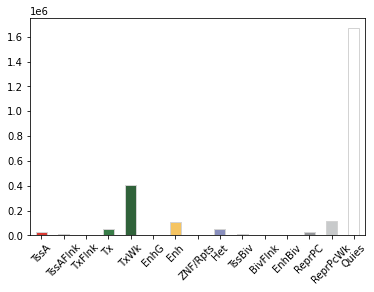

In [55]:
color_dec=colors2color_dec(css_color_dict)
ax0=count_all_renamed.loc[:,"chr1"].plot.bar(rot=45, color=color_dec, edgecolor="lightgray")  # total state

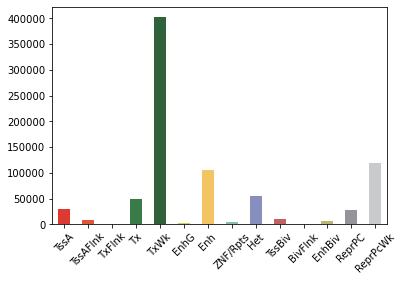

In [56]:
ax1=count_all_renamed.loc[:,"chr1"][:-1].plot.bar(rot=45, color=color_dec)  # except for Quies

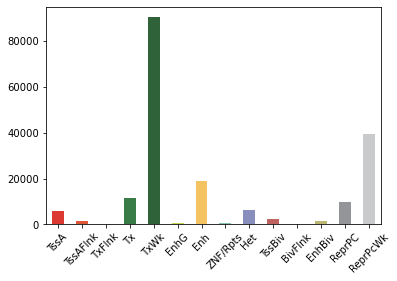

In [68]:
ax1=count_all_renamed.loc[:,"chr22"][:-1].plot.bar(rot=45, color=color_dec)  # except for Quies

In [43]:
# df_test=json.load("./cell_json/df_cell001.json")
# df_test